In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail/Online Retail.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings

# Suppressings warnings for cleaner output
warnings.filterwarnings('ignore')

print("--- Starting Online Retail High-Value Customer Purchase Prediction Project (Enhanced RFM & Feature Engineering) ---")
print("Target: Predict if a customer is a 'High-Value Customer' based on their total spend.")
print("Libraries loaded successfully.")

2025-07-23 16:33:02.687121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753288382.944452      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753288383.022259      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Starting Online Retail High-Value Customer Purchase Prediction Project (Enhanced RFM & Feature Engineering) ---
Target: Predict if a customer is a 'High-Value Customer' based on their total spend.
Libraries loaded successfully.


## Loading the Data

In [3]:
file_path = '/kaggle/input/online-retail/Online Retail.csv'

df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
print(f"Dataset loaded from {file_path}. Shape: {df.shape}")

Dataset loaded from /kaggle/input/online-retail/Online Retail.csv. Shape: (541909, 8)


In [4]:
print("Initial DataFrame Info:")
df.info()
print("\nInitial DataFrame Head:")
print(df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Initial DataFrame Head:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE  

## Preprocessing & Feature Engineering

In [5]:
# Calculating the TotalPrice for each transaction line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("Calculated 'TotalPrice' (Quantity * UnitPrice).")

# Handle missing CustomerID: Dropping the rows with missing CustomerID as I am trying to predict the customer value
initial_rows = df.shape[0]
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows with missing CustomerID. New shape: {df.shape}")

# Handle Returns (negative Quantity/TotalPrice): For predicting purchases, removing the returns for simplicity(Reminder-1)
df = df[df['Quantity'] > 0].copy() 
print(f"Removed rows with Quantity <= 0 (returns/cancellations). New shape: {df.shape}")

# Converting InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("Converted 'InvoiceDate' to datetime objects.")

Calculated 'TotalPrice' (Quantity * UnitPrice).
Dropped 135080 rows with missing CustomerID. New shape: (406829, 9)
Removed rows with Quantity <= 0 (returns/cancellations). New shape: (397924, 9)
Converted 'InvoiceDate' to datetime objects.


## Analysing the Recency,Frequency and Monetary data of the Customers

In [6]:
# Calculating a reference date for Recency (one day after the last invoice in the dataset)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot date for Recency calculation: {snapshot_date}")

# RFM Calculation and additional customer-level aggregations
customer_df = df.groupby('CustomerID').agg(
    # Monetary
    TotalSpend=('TotalPrice', 'sum'),
    AvgOrderValue=('TotalPrice', 'mean'), # Avg value per item in an order
    NumItemsPurchased=('Quantity', 'sum'), # Total quantity of items purchased

    # Frequency
    NumInvoices=('InvoiceNo', 'nunique'), # Number of distinct invoices
    NumUniquePurchaseDays=('InvoiceDate', lambda x: x.dt.date.nunique()), # Number of distinct days they purchased

    # Recency
    LastPurchaseDate=('InvoiceDate', 'max'),

    # Other customer-level features
    AvgUnitPriceAllItems=('UnitPrice', 'mean'),
    NumUniqueProducts=('StockCode', 'nunique')
).reset_index()

# Calculate Recency after aggregation
customer_df['Recency'] = (snapshot_date - customer_df['LastPurchaseDate']).dt.days

# Feature: Customer Lifespan / Duration (days between first and last purchase)
first_purchase_date_series = df.groupby('CustomerID')['InvoiceDate'].min()
customer_df = customer_df.merge(first_purchase_date_series.rename('FirstPurchaseDate'), on='CustomerID', how='left')
customer_df['CustomerLifespan'] = (customer_df['LastPurchaseDate'] - customer_df['FirstPurchaseDate']).dt.days

# Handle cases where CustomerLifespan is 0 (single purchase day) to avoid division by zero
# Set to 1 to ensure a non-zero denominator for frequency calculations
customer_df['CustomerLifespan'].replace(0, 1, inplace=True)

# Feature: Purchase Frequency per Lifespan
customer_df['PurchaseFreqPerLifespan'] = customer_df['NumInvoices'] / customer_df['CustomerLifespan']
customer_df['UniqueDayFreqPerLifespan'] = customer_df['NumUniquePurchaseDays'] / customer_df['CustomerLifespan']


# Merge back Country for categorical encoding (most frequent country for the customer)
customer_country = df.groupby('CustomerID')['Country'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').reset_index()
customer_df = customer_df.merge(customer_country, on='CustomerID', how='left')
print("Merged back customer's most frequent country.")


print(f"Aggregated data to customer level with enhanced RFM and other features. Shape: {customer_df.shape}")
print("Customer DataFrame Head with new features:")
print(customer_df.head())

Snapshot date for Recency calculation: 2011-12-10 12:50:00
Merged back customer's most frequent country.
Aggregated data to customer level with enhanced RFM and other features. Shape: (4339, 15)
Customer DataFrame Head with new features:
   CustomerID  TotalSpend  AvgOrderValue  NumItemsPurchased  NumInvoices  \
0     12346.0    77183.60   77183.600000              74215            1   
1     12347.0     4310.00      23.681319               2458            7   
2     12348.0     1797.24      57.975484               2341            4   
3     12349.0     1757.55      24.076027                631            1   
4     12350.0      334.40      19.670588                197            1   

   NumUniquePurchaseDays    LastPurchaseDate  AvgUnitPriceAllItems  \
0                      1 2011-01-18 10:01:00              1.040000   
1                      7 2011-12-07 15:52:00              2.644011   
2                      4 2011-09-25 13:13:00              5.764839   
3                      1 

## Target variable

In [7]:
# Defining 'High-Value' based on TotalSpend.
# Let's use the 80th percentile as the threshold for 'high-value'.
spend_threshold = customer_df['TotalSpend'].quantile(0.80)
customer_df['is_high_value'] = (customer_df['TotalSpend'] >= spend_threshold).astype(int)

print(f"Defined 'is_high_value' target based on TotalSpend >= {spend_threshold:.2f}.")
print("Target variable 'is_high_value' created (1=High-Value, 0=Not High-Value).")

# Dropping original spend, and date columns used for feature engineering
customer_df.drop(columns=['TotalSpend', 'FirstPurchaseDate', 'LastPurchaseDate'], inplace=True)
print("Dropped 'TotalSpend' (used for target) and original date columns.")

Defined 'is_high_value' target based on TotalSpend >= 2057.91.
Target variable 'is_high_value' created (1=High-Value, 0=Not High-Value).
Dropped 'TotalSpend' (used for target) and original date columns.


## EDA - Visualization at Customer Level

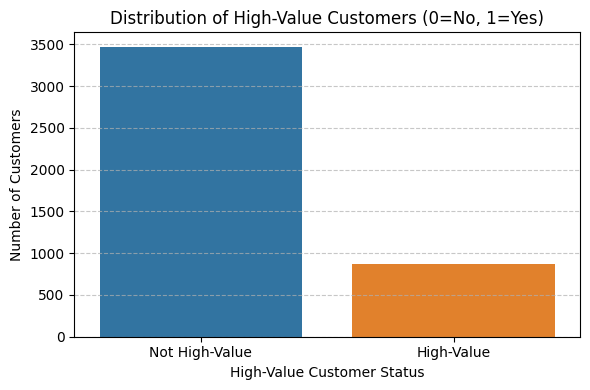

Displayed distribution of the target variable.


In [8]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_high_value', data=customer_df)
plt.title('Distribution of High-Value Customers (0=No, 1=Yes)')
plt.xlabel('High-Value Customer Status')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Not High-Value', 'High-Value'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Displayed distribution of the target variable.")

## RFM distributions


--- RFM Feature Distributions ---


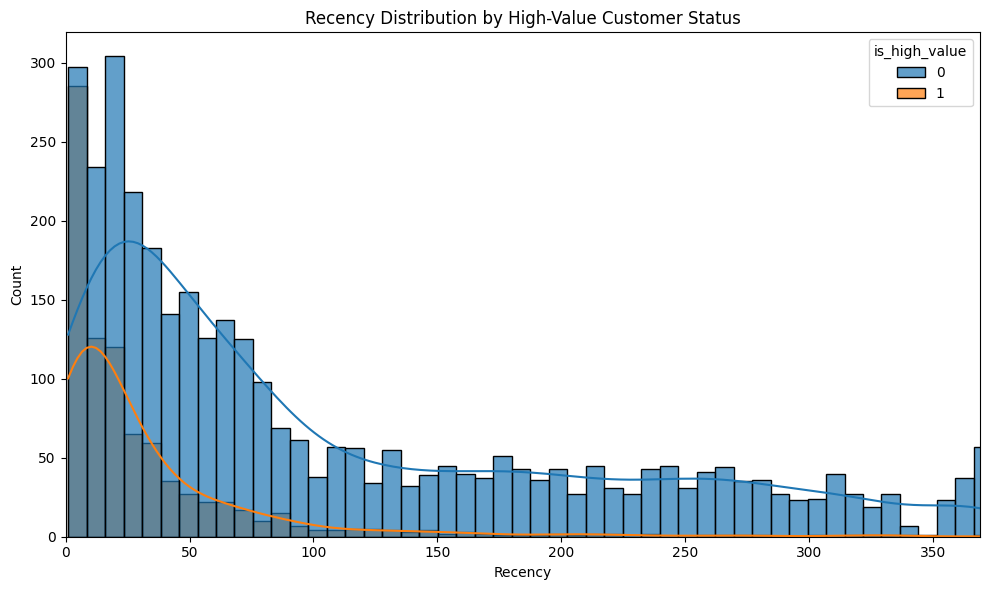

Displayed Recency distribution.


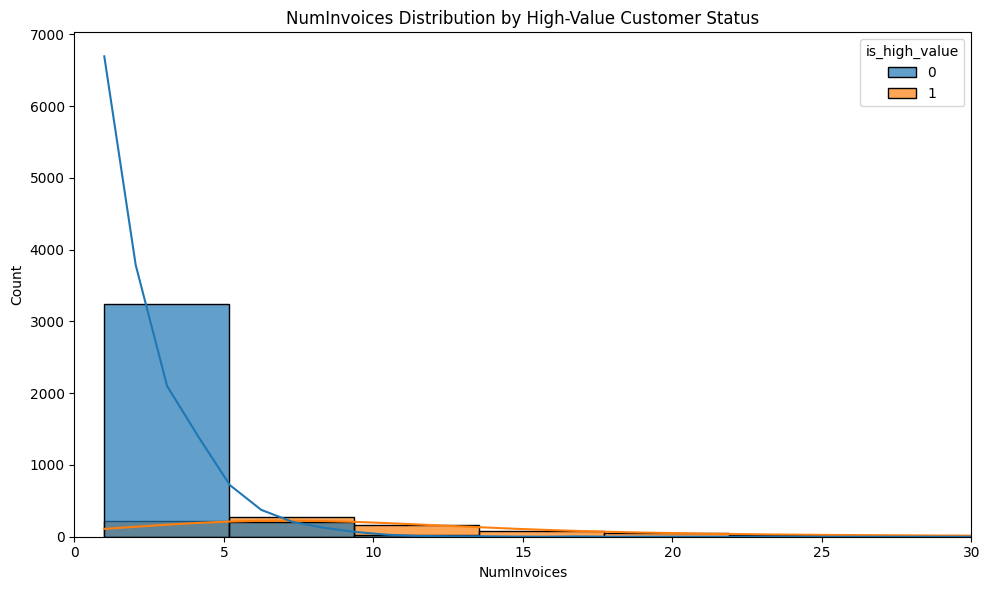

Displayed NumInvoices distribution.


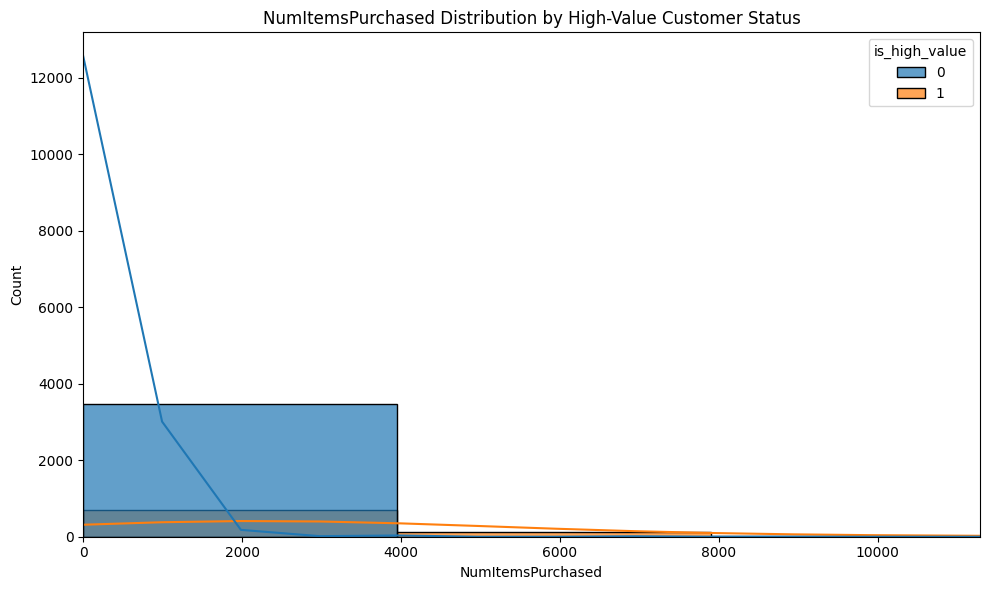

Displayed NumItemsPurchased distribution.


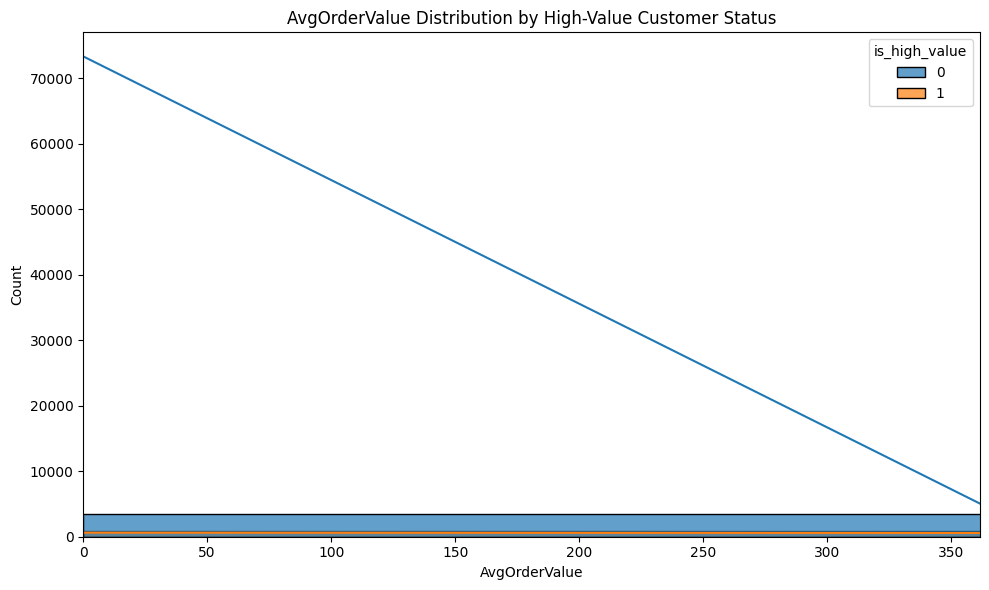

Displayed AvgOrderValue distribution.


In [9]:
print("\n--- RFM Feature Distributions ---")
rfm_features = ['Recency', 'NumInvoices', 'NumItemsPurchased', 'AvgOrderValue']
for feature in rfm_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=customer_df, x=feature, hue='is_high_value', kde=True, bins=50, alpha=0.7)
    plt.title(f'{feature} Distribution by High-Value Customer Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    if feature == 'Recency':
        plt.xlim(0, customer_df['Recency'].quantile(0.99))
    elif feature == 'NumInvoices':
        plt.xlim(0, customer_df['NumInvoices'].quantile(0.99))
    elif feature == 'NumItemsPurchased':
        plt.xlim(0, customer_df['NumItemsPurchased'].quantile(0.99))
    elif feature == 'AvgOrderValue':
        plt.xlim(0, customer_df['AvgOrderValue'].quantile(0.99)) 
    plt.tight_layout()
    plt.show()
    print(f"Displayed {feature} distribution.")


--- RFM Feature Box Plots by High-Value Status ---


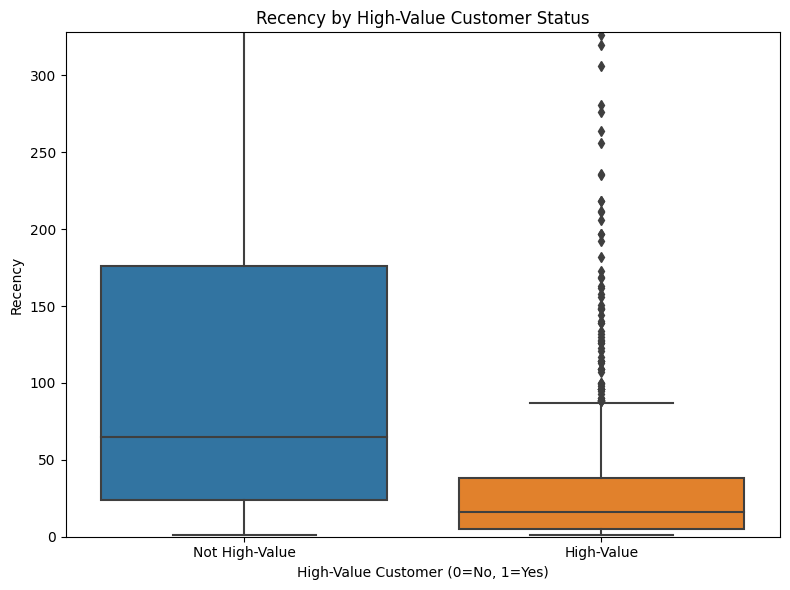

Displayed Box Plot for Recency.


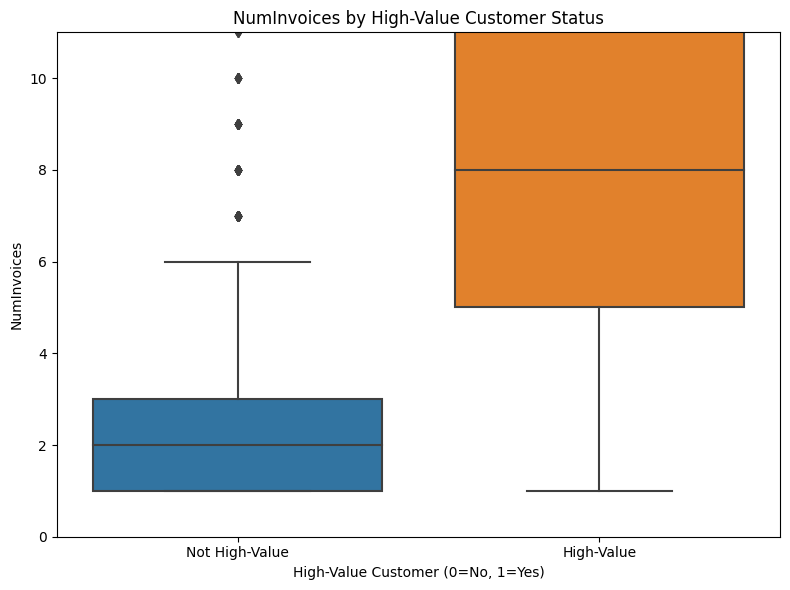

Displayed Box Plot for NumInvoices.


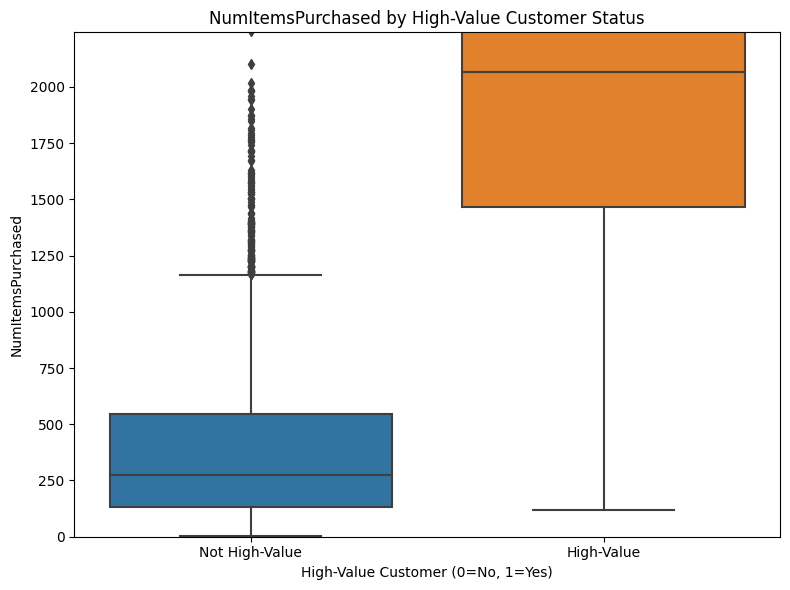

Displayed Box Plot for NumItemsPurchased.


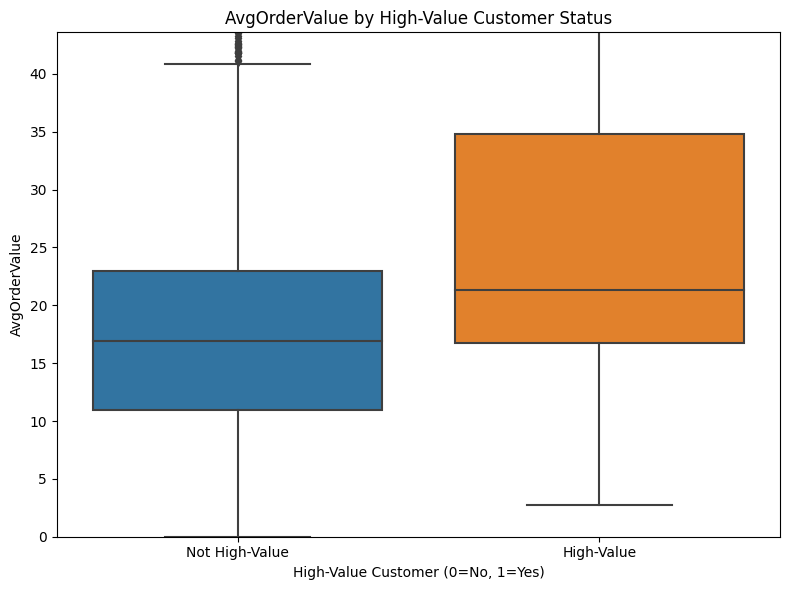

Displayed Box Plot for AvgOrderValue.


In [10]:
print("\n--- RFM Feature Box Plots by High-Value Status ---")
for feature in rfm_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_high_value', y=feature, data=customer_df)
    plt.title(f'{feature} by High-Value Customer Status')
    plt.xlabel('High-Value Customer (0=No, 1=Yes)')
    plt.ylabel(feature)
    Q1 = customer_df[feature].quantile(0.25)
    Q3 = customer_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    plt.ylim(0, upper_bound)
    plt.xticks([0, 1], ['Not High-Value', 'High-Value'])
    plt.tight_layout()
    plt.show()
    print(f"Displayed Box Plot for {feature}.")


 Pairplot for Key RFM Features (Sampled)


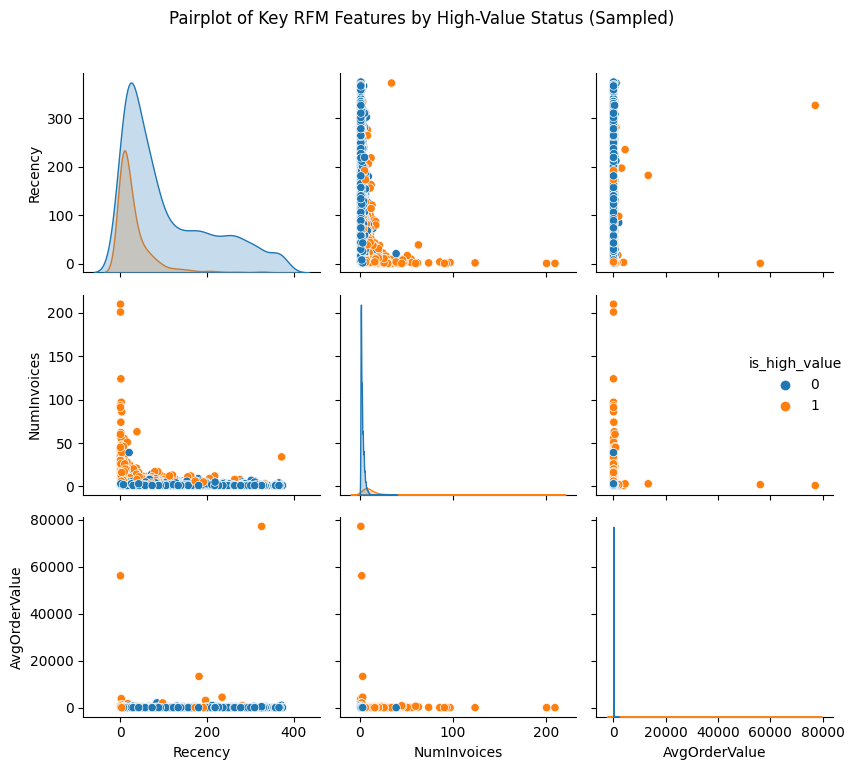

Displayed Pairplot for key RFM features.


In [11]:
print("\n Pairplot for Key RFM Features (Sampled)")

if customer_df.shape[0] > 10000:
    sample_df = customer_df.sample(n=10000, random_state=42)
else:
    sample_df = customer_df.copy()
pairplot_features = ['Recency', 'NumInvoices', 'AvgOrderValue', 'is_high_value']
pairplot_features = [f for f in pairplot_features if f in sample_df.columns]

if len(pairplot_features) > 1: 
    sns.pairplot(sample_df[pairplot_features], hue='is_high_value', diag_kind='kde')
    plt.suptitle('Pairplot of Key RFM Features by High-Value Status (Sampled)', y=1.02) 
    plt.tight_layout()
    plt.show()
    print("Displayed Pairplot for key RFM features.")
else:
    print("Not enough selected features for a meaningful Pairplot.")


 High-Value Customer Count by Country (Top 10) 


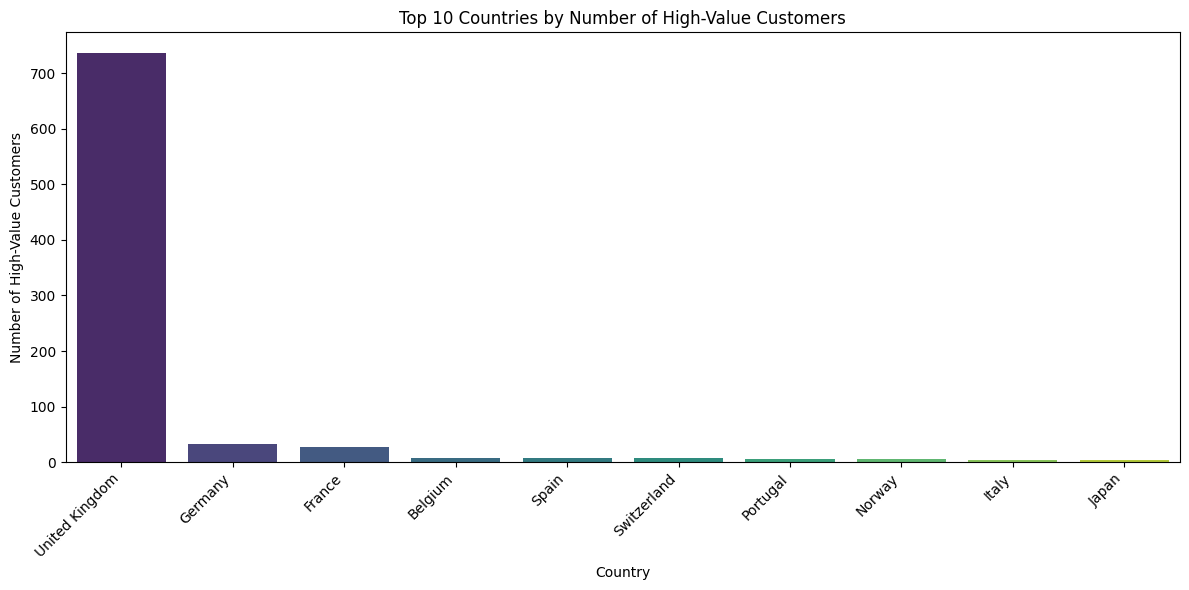

Displayed Top 10 Countries by High-Value Customer count.


In [12]:
print("\n High-Value Customer Count by Country (Top 10) ")
if 'Country' in customer_df.columns:
    high_value_by_country = customer_df[customer_df['is_high_value'] == 1]['Country'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=high_value_by_country.index, y=high_value_by_country.values, palette='viridis')
    plt.title('Top 10 Countries by Number of High-Value Customers')
    plt.xlabel('Country')
    plt.ylabel('Number of High-Value Customers')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("Displayed Top 10 Countries by High-Value Customer count.")

In [13]:
# NEW INSIGHTS SECTION 
print("\n Insights from EDA ")
print("Based on the visualizations, here are some key insights:")

# Insight 1: Target Variable Imbalance
high_value_count = customer_df['is_high_value'].sum()
total_customers = customer_df.shape[0]
high_value_percentage = (high_value_count / total_customers) * 100
print(f"1. **Target Imbalance:** Approximately {high_value_percentage:.2f}% of customers are classified as 'High-Value'. This indicates a class imbalance, where the positive class is a minority. This will be a key consideration for model evaluation (e.g., using AUC, precision/recall over accuracy).")

# Insight 2: Recency vs. High-Value
# From the Recency histogram and box plot, we can infer:
recency_hv_median = customer_df[customer_df['is_high_value'] == 1]['Recency'].median()
recency_nhv_median = customer_df[customer_df['is_high_value'] == 0]['Recency'].median()
print(f"2. **Recency Insight:** High-value customers tend to have lower 'Recency' values (median: {recency_hv_median} days) compared to non-high-value customers (median: {recency_nhv_median} days). This suggests that more recent activity is a strong indicator of a customer being high-value, which aligns with RFM principles.")

# Insight 3: Frequency (NumInvoices) vs. High-Value
# From NumInvoices histogram and box plot:
num_invoices_hv_median = customer_df[customer_df['is_high_value'] == 1]['NumInvoices'].median()
num_invoices_nhv_median = customer_df[customer_df['is_high_value'] == 0]['NumInvoices'].median()
print(f"3. **Frequency Insight:** High-value customers generally have a significantly higher number of invoices (median: {num_invoices_hv_median}) than non-high-value customers (median: {num_invoices_nhv_median}). This indicates that frequent purchases are a strong characteristic of high-value customers.")

# Insight 4: Average Order Value vs. High-Value
# From AvgOrderValue histogram and box plot:
avg_order_value_hv_median = customer_df[customer_df['is_high_value'] == 1]['AvgOrderValue'].median()
avg_order_value_nhv_median = customer_df[customer_df['is_high_value'] == 0]['AvgOrderValue'].median()
print(f"4. **Monetary Insight (Avg Order Value):** High-value customers tend to have a higher average order value (median: ${avg_order_value_hv_median:.2f}) compared to non-high-value customers (median: ${avg_order_value_nhv_median:.2f}). This suggests that it's not just frequency but also the value of individual transactions that defines high-value customers.")

# Insight 5: Unique Products vs. High-Value
num_unique_products_hv_median = customer_df[customer_df['is_high_value'] == 1]['NumUniqueProducts'].median()
num_unique_products_nhv_median = customer_df[customer_df['is_high_value'] == 0]['NumUniqueProducts'].median()
print(f"5. **Product Diversity Insight:** High-value customers typically purchase a greater variety of unique products (median: {num_unique_products_hv_median}) than non-high-value customers (median: {num_unique_products_nhv_median}). This indicates a broader engagement with the product catalog.")

# Insight 6: Top Countries
if 'Country' in customer_df.columns:
    print(f"6. **Geographical Insight:** The majority of high-value customers, and indeed customers overall, are from the '{customer_df['Country'].mode()[0]}' followed by other countries as shown in the bar plot. This geographical distribution is crucial for targeted marketing and logistics.")


 Insights from EDA 
Based on the visualizations, here are some key insights:
1. **Target Imbalance:** Approximately 20.00% of customers are classified as 'High-Value'. This indicates a class imbalance, where the positive class is a minority. This will be a key consideration for model evaluation (e.g., using AUC, precision/recall over accuracy).
2. **Recency Insight:** High-value customers tend to have lower 'Recency' values (median: 16.0 days) compared to non-high-value customers (median: 65.0 days). This suggests that more recent activity is a strong indicator of a customer being high-value, which aligns with RFM principles.
3. **Frequency Insight:** High-value customers generally have a significantly higher number of invoices (median: 8.0) than non-high-value customers (median: 2.0). This indicates that frequent purchases are a strong characteristic of high-value customers.
4. **Monetary Insight (Avg Order Value):** High-value customers tend to have a higher average order value (med

## Preprocessing for Neural Network

In [14]:
# Separate features (X) and target (y)
# Dropping CustomerID as it's an identifier, not a feature
X = customer_df.drop(columns=['CustomerID', 'is_high_value'])
y = customer_df['is_high_value']

# Identify categorical and numerical columns for encoding and scaling
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

# One-Hot Encode Categorical Features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"One-hot encoded categorical features. New feature count: {X.shape[1]}")

# Ensuring numerical_cols are updated to reflect all numeric columns now, including dummies
numerical_cols_after_encoding = X.columns # All columns in X are now numerical

# Feature Scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols_after_encoding])

X = pd.DataFrame(X_scaled, columns=numerical_cols_after_encoding, index=X.index)
print("Scaled all numerical features using StandardScaler.")

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True) # Fill any remaining NaNs
print("Handled any remaining NaN/inf values after scaling.")

One-hot encoded categorical features. New feature count: 46
Scaled all numerical features using StandardScaler.
Handled any remaining NaN/inf values after scaling.


## Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")

Data split into training (3471 samples) and testing (868 samples).
Training target distribution:
is_high_value
0    0.800058
1    0.199942
Name: proportion, dtype: float64
Testing target distribution:
is_high_value
0    0.799539
1    0.200461
Name: proportion, dtype: float64


## Building the Neural Network

In [16]:
# Defining the Neural Network model (simple Sequential model)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # Input layer + 1st hidden
    Dense(64, activation='relu'),                                  # 2nd hidden layer
    Dense(32, activation='relu'),                                  # 3rd hidden layer
    Dense(1, activation='sigmoid')                                 # Output layer for binary classification
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()
print("Neural Network model defined and compiled.")

print("Training the model... (this might take a few moments)")
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_split=0.1, verbose=0)
print("Model training complete.")

2025-07-23 16:33:30.980516: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,385 (64.00 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 0 (0.00 B)

Neural Network model defined and compiled.
Training the model... (this might take a few moments)
Model training complete.


## Predictions

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       694
           1       0.86      0.77      0.81       174

    accuracy                           0.93       868
   macro avg       0.90      0.87      0.89       868
weighted avg       0.93      0.93      0.93       868



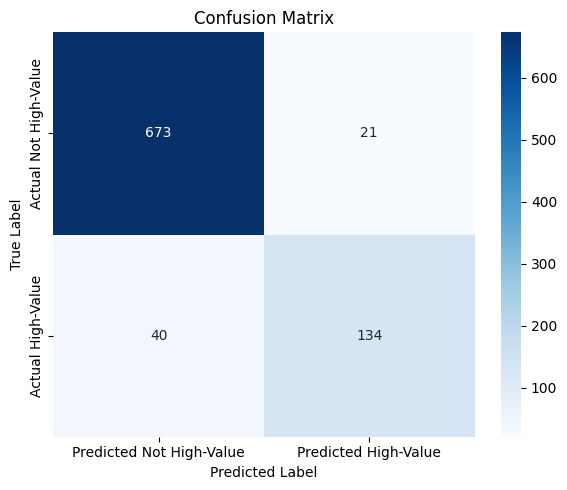

Displayed Confusion Matrix.

ROC AUC Score: 0.9744


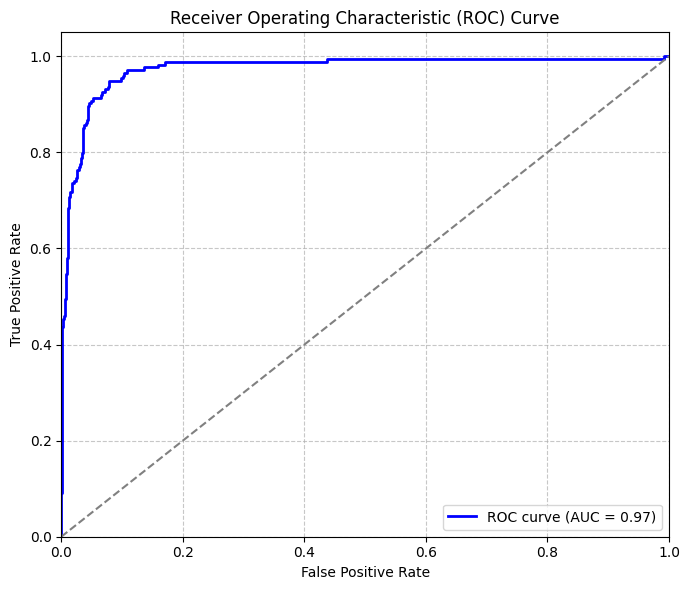

Displayed ROC Curve.


In [17]:
# Predicting probabilities on the test set
y_pred_proba = model.predict(X_test).ravel()

# Convert probabilities to binary predictions (threshold 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Printing Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plotting Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not High-Value', 'Predicted High-Value'],
            yticklabels=['Actual Not High-Value', 'Actual High-Value'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
print("Displayed Confusion Matrix.")

# Calculating ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Displayed ROC Curve.")


--- Precision-Recall Curve ---


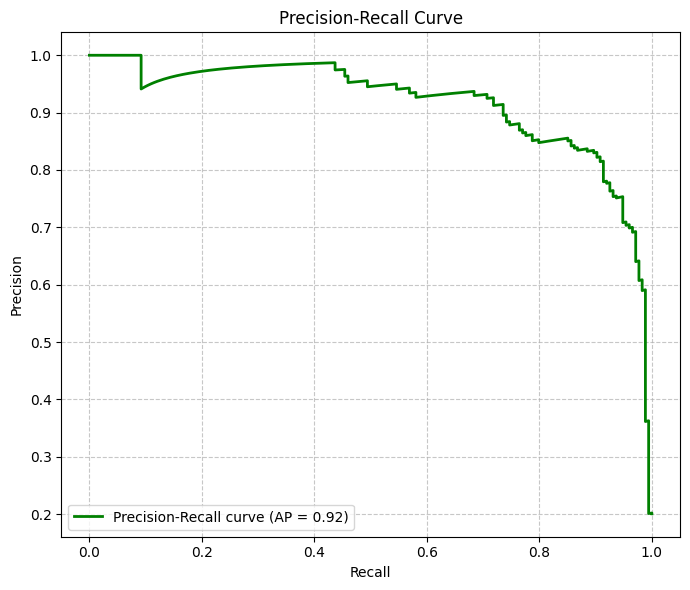

Displayed Precision-Recall Curve (Average Precision = 0.9173).


In [18]:
# Precision-Recall Curve
print("\n--- Precision-Recall Curve ---")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"Displayed Precision-Recall Curve (Average Precision = {avg_precision:.4f}).")


--- Distribution of Predicted Probabilities ---


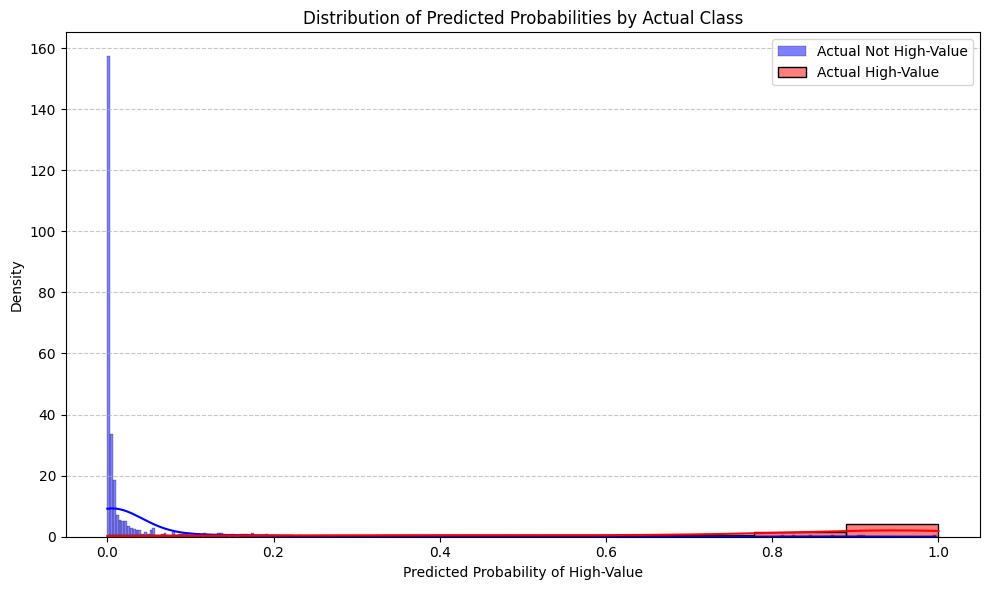

Displayed Distribution of Predicted Probabilities.


In [19]:
# Distribution of Predicted Probabilities
print("\n--- Distribution of Predicted Probabilities ---")
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba[y_test == 0], color='blue', kde=True, stat='density', alpha=0.5, label='Actual Not High-Value')
sns.histplot(y_pred_proba[y_test == 1], color='red', kde=True, stat='density', alpha=0.5, label='Actual High-Value')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.xlabel('Predicted Probability of High-Value')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Displayed Distribution of Predicted Probabilities.")